In [1]:
import vonenet
import torchvision
import torch

# Load V1 model
# v1_model = vonenet.get_model(model_arch=None, pretrained=False, noise_mode=None).module
# v1_model = vonenet.get_model(model_arch='cornets', pretrained=False, noise_mode=None, image_size=32, visual_degrees=3, sf_max=5, stride=1, ksize=15).module
v1_model = vonenet.get_model(model_arch='cornets', pretrained=True, noise_mode="neuronal").module
data_path = '/Users/jcc/Desktop/v1/vonenet/val'

bsize = 16
crop = 256 # 48  256
px = 224 # 32  224
normalize = torchvision.transforms.Normalize(mean=[0.5, 0.5, 0.5],
                                             std=[0.5, 0.5, 0.5]) #归一化处理方便gpu计算
dataset = torchvision.datasets.ImageFolder(data_path,
    torchvision.transforms.Compose([
        torchvision.transforms.Resize(crop),  
        torchvision.transforms.CenterCrop(px),  
        torchvision.transforms.ToTensor(),
        normalize,
    ]))
data_loader = torch.utils.data.DataLoader(dataset, batch_size=bsize, shuffle=False, num_workers=4, pin_memory=True)

# Visualization
import numpy as np
import matplotlib.pyplot as plt

def plotlayerxtrial(block, layer_n):
    """
    Plots the response of the trials from V1_np block at the specified layer.

    Parameters:
    block : numpy array
        A 4D array representing [trial, layer, x, y] activations of a neural network.
    layer_n : int
        The specific layer for which the response is plotted.
    """
    mean_i = np.mean(block, axis=0)  # calculate the mean over trials (optional if needed)
    
    fig, axes = plt.subplots(2, 5, figsize=(15, 6), constrained_layout=True)  # 2x5 grid
    m_ref = block  # reference to the block

    for idx in range(10):  # plotting for 10 trials
        ax = axes[idx // 5, idx % 5]  # select subplot position
        img = ax.imshow(m_ref[idx, layer_n, :, :], cmap='seismic', interpolation='none', vmin=-2, vmax=2)
        ax.set_title(f'Trial = {idx+1}')
        ax.axis('off')  # hide the axis
    
    fig.colorbar(img, ax=axes, orientation='horizontal', fraction=0.05, pad=0.05)  # add colorbar
    plt.suptitle(f'Responses for Layer {layer_n}')
    plt.show()
# Example usage:
# Assuming V1_np is a 4D array with shape (trials, layers, x, y)
# plotlayerxtrial(V1_np,20) # (block_name, #layer)
# plotlayerxtrial(actdict['V2'].numpy()[:, :, V2_position[0]:V2_position[0] + V2_size_side,
                    # V2_position[1]:V2_position[1] + V2_size_side],20)
def plotlayer_threshold_trials(block, layer_n=1, thr_int=(-0, 0),isFluctuation=False):
    """
    Plots the fluctuations of each trial from V1_np block at the specified layer, 
    with the option to zero out values within a given threshold interval.

    Parameters:
    block : numpy array
        A 4D array representing [trial, layer, x, y] activations of a neural network.
    layer_n : int
        The specific layer for which the response is plotted.
    thr_int : tuple, optional
        Threshold interval. Values between thr_int[0] and thr_int[1] are set to 0 (default is (-0.7, 0.7)).
    """

    mean_i = np.mean(block, axis=0)  # calculate the mean across trials
    
    fig, axes = plt.subplots(2, 5, figsize=(15, 6), constrained_layout=True)  # 2x5 grid
    
    for idx in range(10):  # plotting for 10 trials
        ax = axes[idx // 5, idx % 5]  # select subplot position

        # Calculate the fluctuation (trial response - mean response for the layer)
        if isFluctuation:
            m_ref = block[idx, layer_n, :, :] - mean_i[layer_n, :, :]
            m_ref[(mean_i[layer_n] >= thr_int[0]) & (mean_i[layer_n] <= thr_int[1])] = 0
        else:
            m_ref = block[idx, layer_n, :, :]
            m_ref[(mean_i[layer_n] >= thr_int[0]) & (mean_i[layer_n] <= thr_int[1])] = 0

        # Zero out values in the specified threshold interval
        
        # Plot the result using the 'bwr' colormap
        img = ax.imshow(m_ref, cmap='bwr', interpolation='none', vmin=-5, vmax=5)
        ax.set_title(f'Trial = {idx+1}')
        ax.axis('off')  # hide the axis
    
    # Add a colorbar to the figure
    fig.colorbar(img, ax=axes, orientation='horizontal', fraction=0.05, pad=0.05)
    plt.suptitle(f'Fluctuations of each trial at layer {layer_n}')
    plt.show()
# Example usage:
# Assuming V1_np is a 4D array with shape (trials, layers, x, y)
# V1_np = np.random.randn(20, 502, 64, 64)  # dummy
# plotlayer_threshold_trials(V1_np, 10, isFluctuation=True)
def get_activation(name):
    def hook(model, input, output):
        actdict[name] = output.detach()
    return hook

Neuronal distributions gabor parameters
Model:  VOneCORnet-S


/Users/jcc/Desktop/v1/vonenet/vonenet/params.py:59: RuntimeWarning: invalid value encountered in divide
  ny_dist_marg = n_joint_dist / n_joint_dist.sum(axis=1, keepdims=True)
/Users/jcc/Desktop/v1/vonenet/venv/lib/python3.9/site-packages/torch/functional.py:512: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at /Users/runner/work/pytorch/pytorch/pytorch/aten/src/ATen/native/TensorShape.cpp:3588.)
  return _VF.meshgrid(tensors, **kwargs)  # type: ignore[attr-defined]


In [23]:
v1_model.vone_block.noise_mode=None
print(v1_model.vone_block.noise_scale)
v1_model.vone_block.noise_level = 0
print(v1_model.vone_block.noise_level)
print(v1_model.vone_block.noise_mode)
print(v1_model.model.V2.times)

0.35
0
None
2


In [3]:
print(v1_model)

Sequential(
  (vone_block): VOneBlock(
    (simple_conv_q0): GFB()
    (simple_conv_q1): GFB()
    (simple): ReLU(inplace=True)
    (complex): Identity()
    (gabors): Identity()
    (noise): ReLU(inplace=True)
    (output): Identity()
  )
  (bottleneck): Conv2d(512, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
  (model): CORnetSBackEnd(
    (V2): CORblock_S(
      (conv_input): Conv2d(64, 128, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (skip): Conv2d(128, 128, kernel_size=(1, 1), stride=(2, 2), bias=False)
      (norm_skip): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv1): Conv2d(128, 512, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (nonlin1): ReLU(inplace=True)
      (conv2): Conv2d(512, 512, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
      (nonlin2): ReLU(inplace=True)
      (conv3): Conv2d(512, 128, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (nonlin3): ReLU(inplace=True)
      (out

In [24]:

dataloader_iterator = iter(data_loader)
actdict = {}
X, _ = next(dataloader_iterator)
v1_model.eval()
activations = v1_model(X)

# Add hooks to the layer to be investigated
v1_model.vone_block.complex.register_forward_hook(get_activation('complex'))
v1_model.vone_block.gabors.register_forward_hook(get_activation('gabors'))
v1_model.vone_block.noise.register_forward_hook(get_activation('noise'))
v1_model.vone_block.output.register_forward_hook(get_activation('V1'))
# For networks with name purely in number
# vone_block_0 = getattr(v1_model.model.layer1, '0')  # Access the layer '0' in layer1
# vone_block_0.conv1.register_forward_hook(get_activation('layer1conv3'))
v1_model.model.V2.conv_input.register_forward_hook(get_activation('V2input'))
v1_model.model.V2.conv1.register_forward_hook(get_activation('V2conv1'))
v1_model.model.V2.output.register_forward_hook(get_activation('V2'))

v1_model.model.V4.register_forward_hook(get_activation('V4'))
v1_model.model.IT.register_forward_hook(get_activation('IT'))
activations = v1_model(X)
# Check the result of classification
print("Predicted class indices:", torch.argmax(torch.nn.functional.softmax(activations, dim=1), dim=1))

Predicted class indices: tensor([619, 619, 619, 619, 619, 619, 619, 619, 619, 619, 619, 619, 619, 619,
        619, 619])


In [25]:
# Cut the receptive field ** This is only for selected V2 >> mapping V1
V2_position=(5, 5)
V1_position = (V2_position[0] * 2-1, V2_position[1] * 2-1)
V2_size_side=1
V1_size_side = (V2_size_side) * 3 

# Get the layer inside the network

complex_rf = actdict['complex'][:, :, V1_position[0]:V1_position[0] + V1_size_side,
        V1_position[1]:V1_position[1] + V1_size_side].numpy()
gabors_rf = actdict['gabors'][:, :, V1_position[0]:V1_position[0] + V1_size_side,
        V1_position[1]:V1_position[1] + V1_size_side].numpy()
noise_rf = actdict['noise'][:, :, V1_position[0]:V1_position[0] + V1_size_side,
        V1_position[1]:V1_position[1] + V1_size_side].numpy()
V1_rf = actdict['V1'][:, :, V1_position[0]:V1_position[0] + V1_size_side,
        V1_position[1]:V1_position[1] + V1_size_side].numpy()
V2_rf = actdict['V2'][:, :, V2_position[0]:V2_position[0] + V2_size_side,
        V2_position[1]:V2_position[1] + V2_size_side].numpy()
V2input_rf = actdict['V2input'][:, :, V1_position[0]:V1_position[0] + V1_size_side,
        V1_position[1]:V1_position[1] + V1_size_side].numpy()
V2conv1_rf = actdict['V2conv1'][:, :, V1_position[0]:V1_position[0] + V1_size_side,
        V1_position[1]:V1_position[1] + V1_size_side].numpy()
# 
# V2_rf = actdict['layer1conv3'][:, :, V2_position[0]:V2_position[0] + V2_size_side,
#         V2_position[1]:V2_position[1] + V2_size_side].numpy()


In [34]:
V1_np = actdict['V1'].numpy()
V2_np = actdict['V2'].numpy()
# V~_np: (batch_size, channels, height, width)
# V1_reshaped = V1_np.reshape(bsize, -1)
print('Size of V1 rf:', V1_np.shape)
# V2_reshaped = V2_np.reshape(bsize, -1)
print('Size of V2:', V2_np.shape)
print('Size of V2int:', actdict['V2conv1'].numpy().shape)


Size of V1 rf: (4, 512, 56, 56)
Size of V2: (4, 128, 28, 28)
Size of V2int: (4, 512, 28, 28)


In [34]:
# Check the result of classification
print("Predicted class indices:", torch.argmax(torch.nn.functional.softmax(activations, dim=1), dim=1))

Predicted class indices: tensor([753, 753, 753, 753])


In [5]:
# Visualization for trial-to-trial response
def display_image(array, cmap='viridis'):
    """
    
    Paras:
    array: 2D NumPy Array
    cmap: Control the color mapping, default to 'viridis'
    """
    fig, ax = plt.subplots()  
    img = ax.imshow(array, cmap=cmap) 
    fig.colorbar(img, ax=ax)

    plt.show()


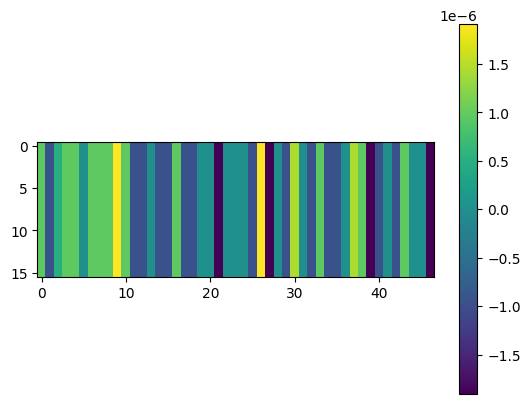

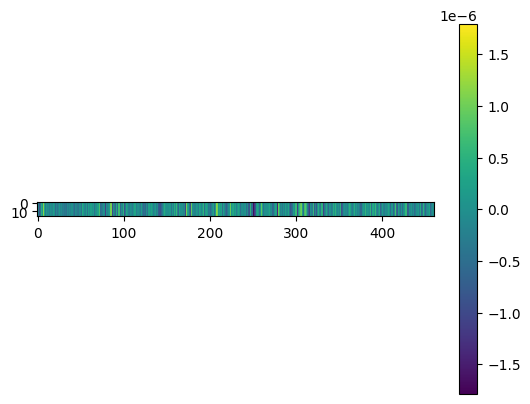

In [26]:
# Example for this
tmp = noise_rf
tmp = tmp.reshape(tmp.shape[0], -1)
col_means = tmp.mean(axis=0)
fluctuations = tmp - col_means
threshold = np.percentile(col_means, 99)  # Eliminate 均值较低的k%单元
V1_sp_select = fluctuations[:, np.where(col_means >= threshold)[0]]
display_image(V1_sp_select)

tmp = V2conv1_rf
tmp = tmp.reshape(tmp.shape[0], -1)
col_means = tmp.mean(axis=0)
fluctuations = tmp - col_means
threshold = np.percentile(col_means, 90)  # Eliminate 均值较低的k%单元
V2_sp_select = fluctuations[:, np.where(col_means >= threshold)[0]]
display_image(V2_sp_select*10)



# V2_sp = V2conv1_rf
# V2_sp = V2_sp.reshape(V2_sp.shape[0],  -1)
# col_means = V2_sp.mean(axis=0)
# 
# threshold = np.percentile(col_means, 90) 
# V2_sp_select = V2_sp[:, col_means >= threshold]
# display_image(V2_sp_select)

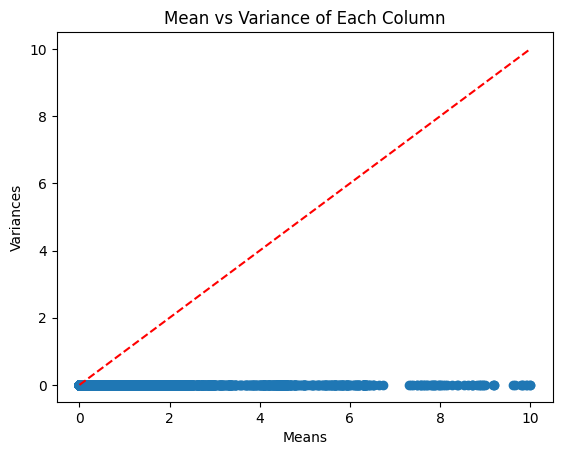

In [27]:
# Check the relation bt means and var
# First get the output of an input image (1st position) of a block
check_image = noise_rf

check_image = check_image.reshape(check_image.shape[0], -1)
col_means = check_image.mean(axis=0)

# threshold = np.percentile(col_means, 97)
# check_image = check_image[:, col_means >= threshold]
# col_means = check_image.mean(axis=0)

col_vars = check_image.var(axis=0)
import matplotlib.pyplot as plt

# 创建散点图
plt.scatter(col_means, col_vars)

x = np.linspace(min(col_means), max(col_means), 100)
plt.plot(x, x, color='red', linestyle='--', label='x = y')

# 添加标题和标签
plt.title('Mean vs Variance of Each Column')
plt.xlabel('Means')
plt.ylabel('Variances')

# 显示图像
plt.show()


Decrease Noise&&V1 20th layer is a good layer for testing as it has 

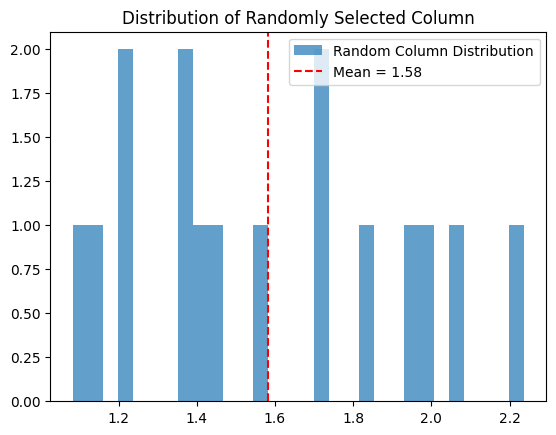

In [22]:
# Check the single neuron distribution
import matplotlib.pyplot as plt
import numpy as np
# 筛选出 mean 大于 1 的列
selected_columns = check_image[:, col_means > 0]
selected_means = col_means[col_means > 0]

# 确保有符合条件的列
if selected_columns.shape[1] > 0:
    # 随机选择一列
    random_index = np.random.randint(0, selected_columns.shape[1])
    random_column = selected_columns[:, random_index]
    random_mean = selected_means[random_index]

    # 绘制分布和均值
    plt.hist(random_column, bins=30, alpha=0.7, label=f'Random Column Distribution')
    plt.axvline(x=random_mean, color='r', linestyle='--', label=f'Mean = {random_mean:.2f}')
    plt.title(f'Distribution of Randomly Selected Column')
    plt.legend()
    plt.show()
else:
    print("没有符合条件的列。")


In [10]:
m_ref = V2_np
mean_i = np.mean(m_ref, axis=0)
layer_n = 22 # from 0-118

fig, axes = plt.subplots(2, 5, figsize=(15, 6),constrained_layout=True)  
for idx, i in enumerate(range(layer_n, layer_n+10)):
    ax = axes[idx // 5, idx % 5]  # 
    ax.imshow(m_ref[idx, layer_n, :, :]-mean_i[layer_n, :, :], cmap='gray', interpolation='none')
    ax.set_title(f'y = {idx}'
                 f'')
    ax.axis('off')  # 隐藏坐标轴

# 调整子图布局并显示颜色条
fig.colorbar(plt.cm.ScalarMappable(cmap='gray'), ax=axes, orientation='horizontal', fraction=0.02, pad=0.04)
plt.suptitle('Grayscale Images of fluctuation of each trial')
plt.tight_layout()
plt.show()

NameError: name 'V2_np' is not defined

Neuronal distributions gabor parameters
Model:  VOneCORnet-S
vone_block: torch.Size([16, 512, 56, 56])
vone_block: Col for sampling [1093 1334 1068 1044 1943 1844  731 1743 1156 1915 1916 1200 1378  123
   55  178 1369  597  897  434 1837  502 1009  329 1973 1972 1212  590
 1301  234  931 1140  279  682  936 1256 1623  405 1306 1849  559  262
  290 1117  661  738  679 1801  719 1259 1611 1294 1865 1281 1592  328
 1909 1299  594   98 1696 1483 1843  713  134  142  506 1685  820  232
  144  548  557  787  337  375 1484 1125  257 1711  202  332  951 1648
  708  444  127  994 1880 1283  918  927   29 1555  620 1456  881  143
  977 1474]


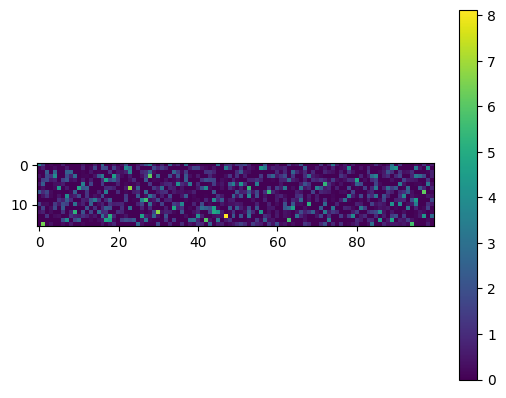

model.V2.conv1: torch.Size([16, 512, 28, 28])
model.V2.conv1: Col for sampling [ 896 1426 1261  586  855 1382 1558  703  724  801  441 1012 1383  558
 1809  598  719  748   49 1540  134 1416  376  140  382  966 1403  935
 1609  696 1632 1626  388  213 1668 1278  442  522 1456   22 1600 1611
   39 1460  619  927  797  386  452  686  199  565  525 1077  572  342
 1467  647  167  249  273 1039 1583 1386  681 1285 1613 1006 1455 1997
  509 1029 1725  547  451 1716 1112 1868 1186 1256 1690  722  592 1594
  391  127  866  888  819  548  259 1591 1132 1680  902 1653 1198  318
   40  541]


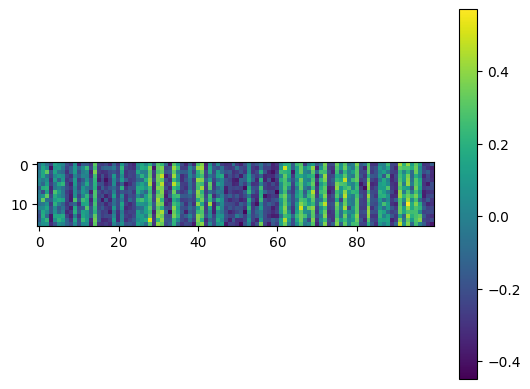

In [14]:
from vonenet.activation import ActivationExtractor

model = vonenet.get_model(model_arch='cornets', pretrained=True, noise_mode="neuronal").module
batch_size = 16
x = torch.randn(batch_size, 3, 224, 224)
# Extract activations from multiple layers
layer_names = [
    'vone_block',  # V1 layer
    'model.V2.conv1',
]

extractor = ActivationExtractor(model, layer_names)
activations = extractor.extract(x)


for layer_name, activation in activations.items():
    col_sp = np.random.choice(2000,100, replace=False)
    print(f"{layer_name}: {activation.shape}")
    resample = activation.reshape(activation.shape[0], -1)[:, col_sp]
    print(f"{layer_name}: Col for sampling {col_sp}")
    display_image(resample)

One approache:
First sampling the one input without noise and add some disturbution to one area, then sampling the same area and check whether each unit is the same or not, figure out the locations of variant units



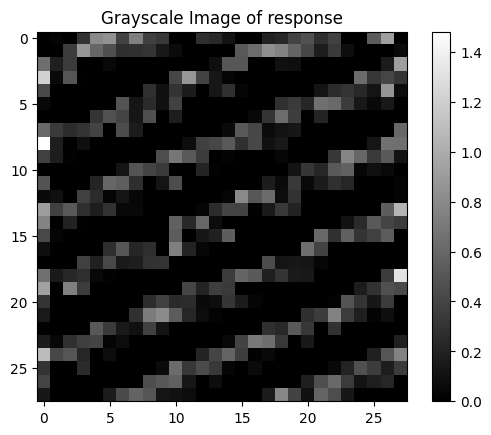

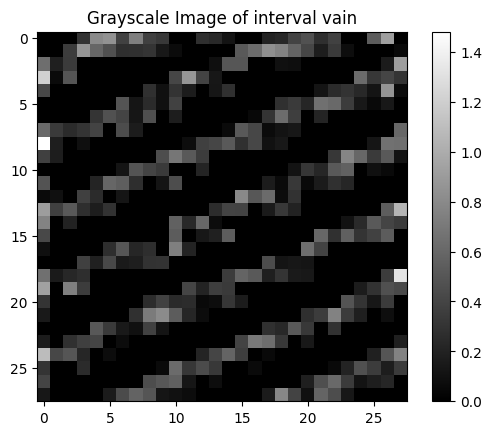

In [324]:
test = m_ref[20, layer_n, :, :]
thr_int = (-0.05, 0.05) 

plt.imshow(test, cmap='gray', interpolation='none')
plt.colorbar()  # 显示颜色条
plt.title('Grayscale Image of response')
plt.show()

test[(test >= thr_int[0]) & (test <= thr_int[1])] = 0
plt.imshow(test, cmap='gray', interpolation='none')
plt.colorbar()  # 显示颜色条
plt.title('Grayscale Image of interval vain')
plt.show()

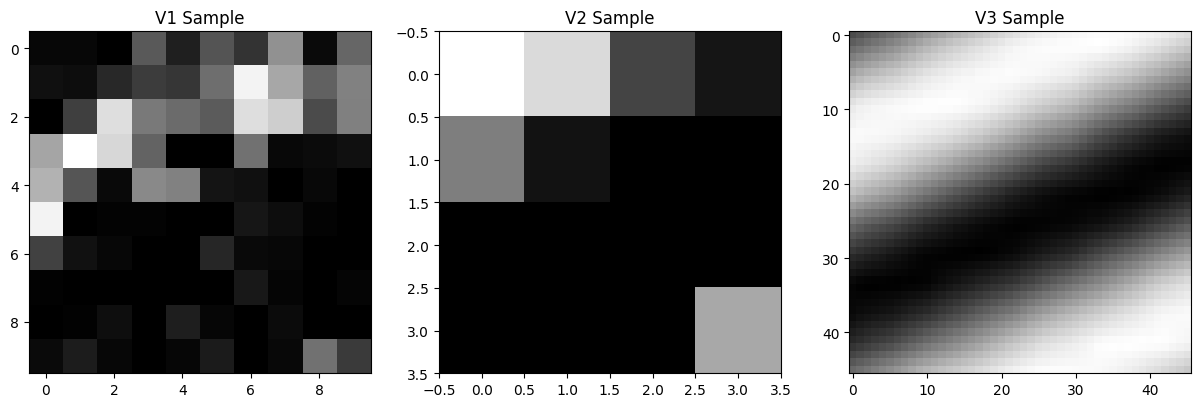

In [376]:
m_ref_V1 = V1_np
m_ref_V2 = V2_np
V2_size_side = 4
V1_size_side = (V2_size_side-1) * 2 + V2_size_side
pic_size_side = (V1_size_side-1) * 4 + V1_size_side
batch_num = 10

# V2 original sampling point 0 ~ 28-V2_size_side
V2_position = (6, 6) 
V1_position = (V2_position[0]*2, V2_position[1]*2)
pic_position = (V1_position[0]*4, V1_position[1]*4)

# 从 V1_position 开始对 m_ref_V1 进行采样
V1_sample = m_ref_V1[batch_num,20, V1_position[0]:V1_position[0] + V1_size_side, V1_position[1]:V1_position[1] + V1_size_side]
V2_sample = m_ref_V2[batch_num,22, V2_position[0]:V2_position[0] + V2_size_side, V2_position[1]:V2_position[1] + V2_size_side]
pic_sample = X[batch_num,0,pic_position[0]:pic_position[0] + pic_size_side, pic_position[1]:pic_position[1] + pic_size_side]
# 显示采样结果（如果需要）
plt.figure(figsize=(15, 5))

plt.subplot(1, 3, 1)
plt.title("V1 Sample")
plt.imshow(V1_sample, cmap='gray')
plt.grid(False)

plt.subplot(1, 3, 2)
plt.title("V2 Sample")
plt.imshow(V2_sample, cmap='gray')
plt.grid(False)

plt.subplot(1, 3, 3)
plt.title("V3 Sample")
plt.imshow(pic_sample, cmap='gray')
plt.grid(False)

plt.show()

In [18]:
# 采样 神经元
import numpy as np
n1s = 30
n2t = 10

# 从数组的列索引中随机选择 n 个索引
n1_ind = np.random.choice(V1_reshaped.shape[1], n1s+n2t, replace=False)
n2_ind = np.random.choice(V2_reshaped.shape[1], n2t, replace=False)

IndexError: index 128 is out of bounds for axis 1 with size 128

In [21]:
import os
V1_src = V1_reshaped[:, n1_ind[:n1s]]
V1_trg = V1_reshaped[:,n1_ind[-n2t:]]
V2_trg = V2_reshaped[:,n2_ind]
# np.savetxt("v1s.csv", V1_src, delimiter=",")
# np.savetxt("v1t.csv", V1_trg, delimiter=",")
# np.savetxt("v2.csv", V2_trg, delimiter=",")
if os.path.exists("v1s.csv"):
    v_existing = np.loadtxt("v1s.csv", delimiter=",")
    v_combined = np.vstack((v_existing, V1_src))
else:
    v_combined = V1_src  # 如果文件不存在，则创建一个空数组
np.savetxt("v1s.csv", v_combined, delimiter=",", fmt='%f') 

if os.path.exists("v1t.csv"):
    v_existing = np.loadtxt("v1t.csv", delimiter=",")
    v_combined = np.vstack((v_existing, V1_trg))
else:
    v_combined = V1_trg  # 如果文件不存在，则创建一个空数组
np.savetxt("v1t.csv", v_combined, delimiter=",", fmt='%f') 

if os.path.exists("v2.csv"):
    v_existing = np.loadtxt("v2.csv", delimiter=",")
    v_combined = np.vstack((v_existing, V2_trg))
else:
    v_existing = V2_trg  # 如果文件不存在，则创建一个空数组
np.savetxt("v2.csv", v_combined, delimiter=",", fmt='%f') 

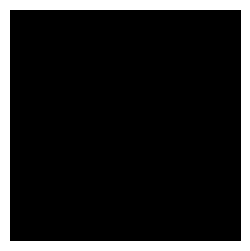

tensor([111, 111, 111, 644, 644, 111, 644, 111, 111, 111, 111, 111, 111, 111,
        111, 111])


In [109]:
# Visualize gratings
import matplotlib.pyplot as plt
im_ind=0

input_im = np.moveaxis(X[im_ind].numpy(),0,-1)
input_im = input_im/2 + 0.5
    
fig, ax = plt.subplots(nrows=1, ncols=1)
fig.set_size_inches(3,3)
im_h=ax.imshow(input_im)
im_h.set_clim([0, 1])
ax.set_axis_off()
plt.show()
# 进行预测，使用softmax对batch内图像进行打标签
import torch.nn.functional as F
predicted_classes = torch.argmax(F.softmax(activations, dim=1), dim=1)
print(predicted_classes)
# tensor([ 16,  16,  16,  16,  16,  22,  16,  16,  16,  16,  16,  14,  16, 998, 16,  16])
# tensor([16, 16, 16, 16, 82, 85, 16, 16, 16, 16, 16, 14, 16, 18, 16, 16, 16, 16, 16, 16, 17, 95, 16, 16, 16, 16])

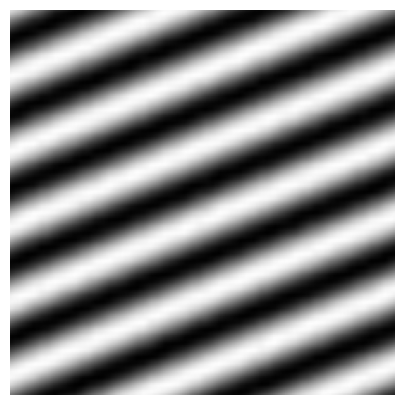

In [363]:

import matplotlib.pyplot as plt
im_ind=15

input_im = np.moveaxis(X[im_ind].numpy(),0,-1)
input_im = input_im/2 +0.5
    
fig, ax = plt.subplots(nrows=1, ncols=1)
fig.set_size_inches(5,5)
im_h=ax.imshow(input_im)
im_h.set_clim([0, 1])
ax.set_axis_off()
plt.show()

In [26]:
# 找出在该图像上响应最一致（标准差最小）和最不一致（标准差最大）的特征
np.argsort(np.std(activations[im_ind].detach().numpy().reshape((500, -1)), axis=1))

array([340,   8,  77, 474, 325, 359, 489, 497, 262, 119, 329, 342,  97,
       239,  99, 130,  67, 437, 250, 187, 397, 275, 106, 185, 304, 473,
       382,  25, 373,  49, 476, 292, 189,  72, 102, 164,   6,   1, 438,
        70,  74, 302,  86,  26, 323, 109,  71,  85, 229, 485, 149, 110,
       192, 156, 459, 190, 175, 458, 448, 449, 480, 467,  50, 232,  14,
        66, 132, 310, 141, 117,  52, 204, 155,  60, 346,  90, 434, 471,
       181,  88, 452, 114, 430,  47, 297,   7, 282, 357, 320, 475, 235,
       483, 105, 296, 139,  94,  76, 385, 353, 380, 368, 330, 316, 284,
        44, 462, 123, 432, 104, 142,  23, 107, 267, 247, 258,  34, 182,
       183, 191,  28, 496, 440, 281, 145, 327,  96, 408, 127, 161,  36,
       162, 280,  78,  54,  10, 165, 202, 133, 121, 401, 113, 115, 470,
       332,  16,  65, 163, 338, 494, 227, 159, 203, 135, 151, 178, 356,
       375, 422, 410, 154, 220,  42, 468,  29, 311, 405, 319,  68, 407,
       209, 144, 224, 261,  11,  13, 477, 198, 254, 301, 495,  5

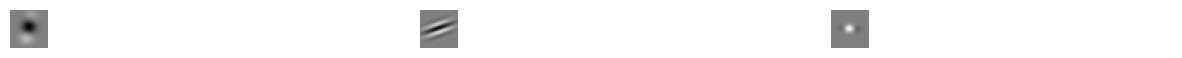

In [64]:
# 如果这个数组与之前讨论的模型激活值有关，那么v1_ind可能表示两个特定的特征索引。
v1_ind=np.array([391, 246, 173])

fig, ax = plt.subplots(nrows=1, ncols=len(v1_ind))
fig.set_size_inches(15,15)
for v1_i, v1_ind_ in enumerate(v1_ind):
    
    v1_k = v1_model.vone_block.simple_conv_q0.weight[v1_ind_,:,:,:].detach().numpy().mean(axis=0)
    v1_k = v1_k / np.amax(np.abs(v1_k))/2+0.5
    im_h=ax[v1_i].imshow(v1_k, cmap='gray')
    ax[v1_i].set_xlim([0, px])
    im_h.set_clim([0, 1])
    ax[v1_i].set_axis_off()
plt.show()




In [29]:
fig, ax = plt.subplots(nrows=1, ncols=len(v1_ind))
fig.set_size_inches(150,150)
max_activations = np.amax(activations.detach().numpy())/np.sqrt(2)

# 需要这个activations截取的一个层（2D的）
for v1_i, v1_ind_ in enumerate(v1_ind):
    v1_im = activations.detach().numpy()
    v1_im = v1_im / max_activations
    im_h=ax[v1_i].imshow(v1_im, cmap='gray')
    im_h.set_clim([0, 1])
    ax[v1_i].set_axis_off()

plt.show()

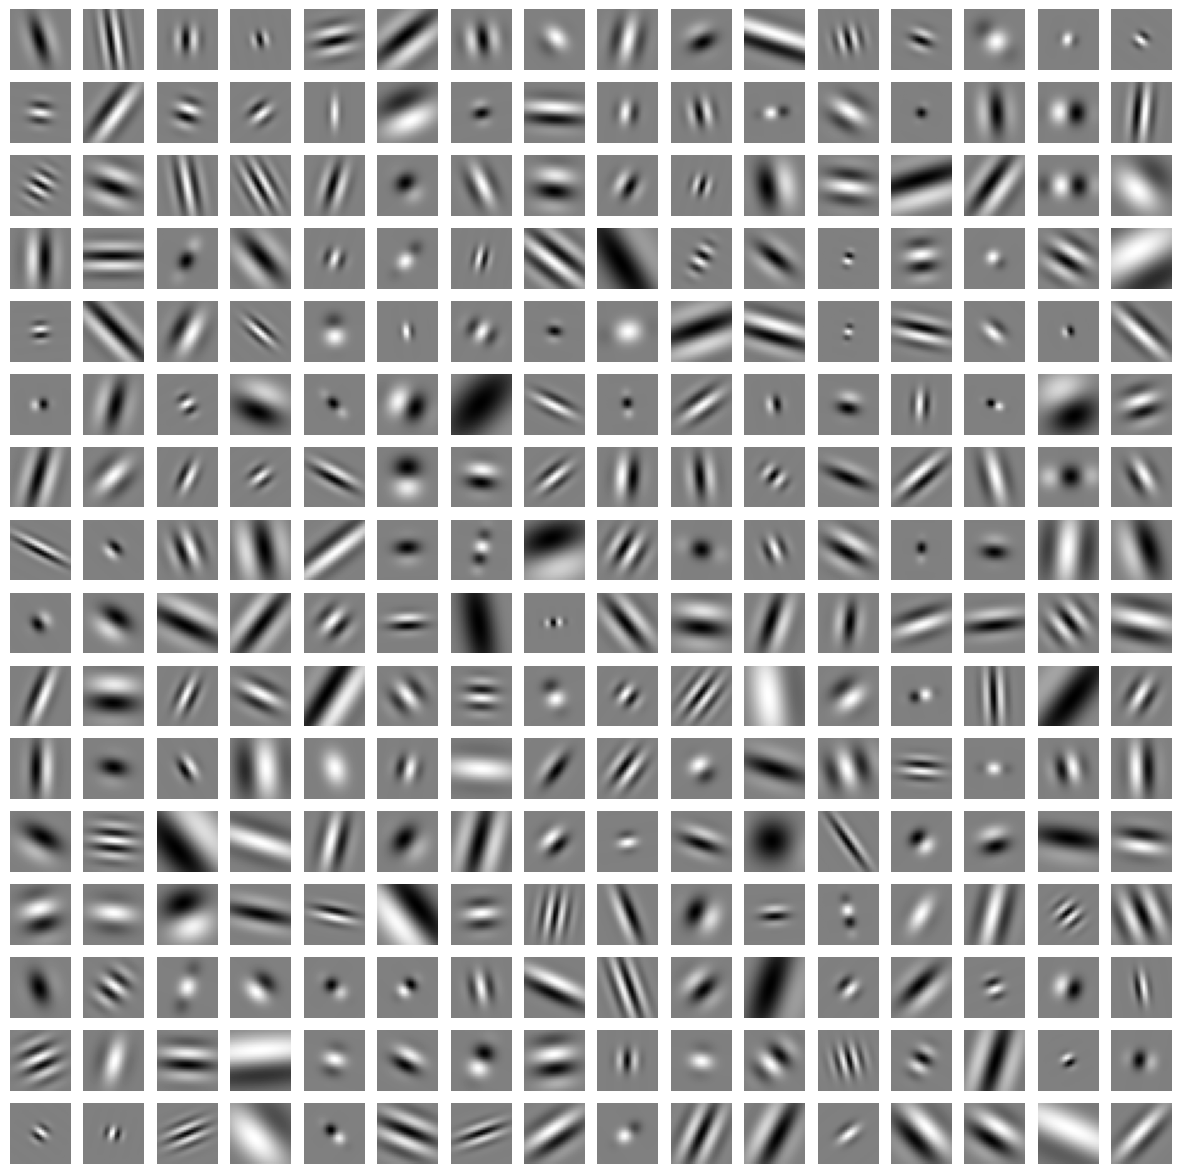

In [65]:
import os
num_channels=256
max_columns = 16

# save_dir = 'gabor_images'
# os.makedirs(save_dir, exist_ok=True)

fig, ax = plt.subplots(nrows=num_channels//max_columns, ncols=max_columns)

fig.set_size_inches(15,15)
for i in range(num_channels):
    v1_k = v1_model.vone_block.simple_conv_q0.weight[i,:,:,:].numpy().mean(axis=0)
    v1_k = v1_k / np.amax(np.abs(v1_k))/2+0.5
    im_h=ax[i//max_columns, np.mod(i,max_columns)].imshow(v1_k, cmap='gray')
#     ax[i//num_channels, np.mod(i,num_channels)].set_xlim([0, 223])
    im_h.set_clim([0, 1])
    ax[i//max_columns, np.mod(i,max_columns)].set_axis_off()

    # 为每个图像设置文件名
#    filename = f'Gabor_val_0000000{i}.jpeg'
    # 保存图像
#    plt.imsave(os.path.join(save_dir, filename), v1_k, cmap='gray', format='jpeg')
plt.show()

In [62]:
# Nyquist

visual_degrees = 8
image_size = 224

nyquist_f = 1/(visual_degrees/image_size)/2 / np.sqrt(2)

print(nyquist_f)

9.899494936611665


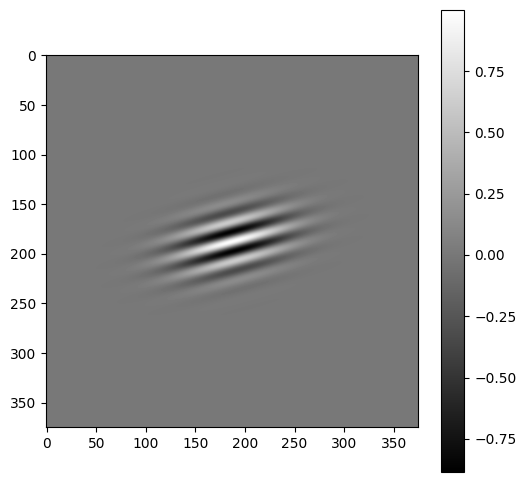

In [3]:
# Generate Granting

def generate_gabor_pytorch(size, sigma, theta, lamda, psi, gamma):
    """
    使用PyTorch生成Gabor滤波器。
    
    参数:
    size : int
        滤波器的大小（width and height）。
    sigma : float
        高斯包络的标准差。
    theta : float
        滤波器的方向（以弧度为单位）。
    lamda : float
        余弦因子的波长。
    psi : float
        相位偏移。
    gamma : float
        空间纵横比。
    """
    # 栅格坐标
    y, x = torch.meshgrid([torch.linspace(-size // 2, size // 2, steps=size),
                           torch.linspace(-size // 2, size // 2, steps=size)])
    x = x.to(torch.float32)
    y = y.to(torch.float32)

    # 旋转坐标
    x_theta = x * torch.cos(theta) + y * torch.sin(theta)
    y_theta = -x * torch.sin(theta) + y * torch.cos(theta)

    # Gabor公式
    gb = torch.exp(-0.5 * (x_theta**2 + gamma**2 * y_theta**2) / sigma**2) * torch.cos(2 * np.pi * x_theta / lamda + psi)
    
    return gb

# 设定参数
size = 375  # 图像大小为375x375
sigma = 20.0
theta = torch.tensor(np.pi / 18*7.5)  # 45度方向
lamda = 20.0
psi = torch.tensor(0.0)
gamma = 0.5

# 生成滤波器
gabor_filter = generate_gabor_pytorch(size, sigma, theta, lamda, psi, gamma)

# 显示滤波器
plt.figure(figsize=(6, 6))
plt.imshow(gabor_filter.numpy(), cmap='gray')
plt.colorbar()
plt.show()

# 保存图像
from PIL import Image

# 将滤波器数据归一化到0-255
gabor_image = (gabor_filter - gabor_filter.min()) / (gabor_filter.max() - gabor_filter.min()) * 255
gabor_image = gabor_image.byte().numpy()  # 转为整数

# 使用PIL保存图像
img = Image.fromarray(gabor_image)
img.save('00000001.jpeg')


In [5]:
from PIL import Image
import torch
import numpy as np
size = 224  # 图像尺寸

def generate_grating(angle_degrees, frequency):
    # 角度转换为弧度
    angle = torch.deg2rad(torch.tensor(float(angle_degrees)))

    # 生成坐标网格
    x = torch.linspace(-np.pi, np.pi, size)
    y = torch.linspace(-np.pi, np.pi, size)
    xv, yv = torch.meshgrid(x, y)

    # 计算光栅
    xv_prime = xv * torch.cos(angle) + yv * torch.sin(angle)
    grating = 0.5 + 0.5 * torch.sin(frequency * xv_prime * 2 * np.pi)

    return grating

# 生成不同方向的光栅
angles = [0,10,20,30,40,50,60,70,80,90,100,110,120,130,140,150,160,170]
repeated_angles = [angle for angle in angles for _ in range(50)]
angles = repeated_angles
for i, angle in enumerate(angles, start=1):
    grating = generate_grating(angle)
    # 将张量转换为图像
    img = Image.fromarray((grating.numpy() * 255).astype(np.uint8))
    img.save(f'0000000{i}.jpeg')
# 
# # 生成空白屏幕
# blank_screen = torch.zeros(size, size)
# img = Image.fromarray((blank_screen.numpy() * 255).astype(np.uint8))
# img.save('00000000.jpeg')


TypeError: generate_grating() missing 1 required positional argument: 'frequency'

In [8]:
import os
save_dir = 'rdm_grating'
if not os.path.exists(save_dir):
    os.makedirs(save_dir)
for _ in range(1000):
    grating = generate_grating(np.random.randint(0, 180),np.random.randint(1, 5))
    # 将张量转换为图像
    img = Image.fromarray((grating.numpy() * 255).astype(np.uint8))
    file_name = f'0000000{_}.jpeg'  # 这里假设_是你想要插入的数字或变量
    full_path = os.path.join(save_dir, file_name)
    img.save(full_path)
